## Summary

The started code of this notebook is based on this colab [notebook](https://colab.research.google.com/github/lucmos/DLAI-s2-2020-tutorials/blob/master/08/8_Variational_Autoencoders_(VAEs).ipynb#scrollTo=pRePt-K1_yw9)

We consider the GBZ settings, we provide below a more detailed explanation on the implementation and the caclulation of a the loss function. Other settings can be implemeented in a similar fashion. The GBZ setting assumes the existance of a latent variable $z$ such that the image $x$ and the label $y$ can be respectively modelled by $p(x|z)$ and $p(y|z)$. 

We now detail provide the implementation details for this notebook. For neural networks we denote the hidden dimension by dimH. Similarly dimZ is the latent variable dimension and dimY is the dimension of one-hot encoded labels i.e. dimY is equal to the number of classes. We assume that an image $x$ is a square pixel gride of length dimX. 

The implementation of GBZ relies on four neural networks with two denoted as decoders and two as encoders. We list the diffent neural networks below:
* An encoder that aims to approximate $p(z|x,y)$. This encoder is made up of two complenents:
    * A CNN $e^1_\theta$ which takes an image $x$ and output a vectore in dimension dimH
    * An MLP $e^2_\theta$ which takes the output of $e^1_\theta$ and a label $y$ to model the latent varibale $z$. More precisely, we use a probabilistic setting such that $\mu, \log(\Sigma) = e^2_\theta(e^1_\theta(x),y)$ and $z\sim \mathcal{N}(\mu, \Sigma)$. Here the $\log$ is used for numerical stability
* A CNN decoder $d^1_\theta(z)$ mapping an latent variable $z$ to an image $x$. This network is implemented as a flipped CNN i.e. a neural network with the head made up of an MLP and followed by a CNN in the final layers. This network aims to approximate $p(y|z)$.
* An MLP decoder $d^2_\theta(z)$ that maps from dimZ to dimY i.e converts a latent variable to a distribution over the labels. This aim to approximate $p(y|z)$

We now descirbe how the training is done over a single example $(x,y)$. This will be applied in the notebook in a minibatch strategy for better computational performance on the parameters.
1. Get the encoding $e= e^1_\theta(x)$
1. Calculate the posterior $\mu, \log(\Sigma) = e^2_\theta(e, y)$
1. sample $K$ random  *posterior* latent varibales $z^1, \ldots,z^K\sim \mathcal{N}(\mu , \Sigma)$
1. calculate the log-likelihood (under the posterior) $q^j = \log(f_{\mathcal{N}(\mu, \Sigma)}(z^j))$ 
1. calculate the log-likelihood (under the gaussian prior) $p^j = \log(f_{\mathcal{N}(0,I)}(z^j))$ 
1. Use the decoder to reconstruct the images $\hat{x}^i=d^1(z^i)$
1. Use the decoder to reconstruct the labels $\hat{y}^i=d^2(z^i)$
1. Calcuale the MSE loss of reconstructured images $l_1^j= ({\hat{x}^j}-x)^2$
1. Claculate the cross-entropy loss of reconstructed labels $l_2^j = \text{CE}(y,\hat{y}^j) $
1. Calculate the total loss $$b^j= (\beta-1) l_1^j+l_2^j+p^j$$
1. Average over the $K$ samples, using a logsumexp function
<!-- 1 $\mu_{r^j_i} = d^2(r_i^j)$ 
1. calculate the term $l_1= \sum_{j=1}^K (\mu_{r_i^j}-r^j_i)^2$
1. calculate the logits over y using $ly_i^j = \text{softmax}(d^1(r_i^j))$
1. calculate the cross_entrop $l_2$between the tryue labels and lhe logits
1. now we calculate 
    1. $b=(\beta-1) l_1 +l_2 +q_i^J$
    1. take a logsumexp of differents $b$ and subtract $\log(K)$ -->

## Imports and Setup

In [1]:
from typing import Mapping, Union, Optional
from pathlib import Path
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import os
import pickle
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(0)

torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True 
torch.backends.cudnn.benchmark = False

## Utils

In [3]:

variational_beta = 1
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    # You can look at the derivation of the KL term here https://arxiv.org/pdf/1907.08956.pdf
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + variational_beta * kldivergence

In [4]:
from typing import Callable, Optional
def make_averager() -> Callable[[Optional[float]], float]:
    """ Returns a function that maintains a running average

    :returns: running average function
    """
    count = 0
    total = 0

    def averager(new_value: Optional[float]) -> float:
        """ Running averager

        :param new_value: number to add to the running average,
                          if None returns the current average
        :returns: the current average
        """
        nonlocal count, total
        if new_value is None:
            return total / count if count else float("nan")
        count += 1
        total += new_value
        return total / count

    return averager

def save_in_dataframe(df_log, labels, mus, stddevs, epoch):
    df = pd.DataFrame()

    df['index'] = np.arange(len(mus[:,0])) * epoch
    df['image_ind'] = np.arange(len(mus[:,0]))
    df['class'] = labels.data.numpy().astype(str)
    df['mu_x'] = mus[:,0]
    df['mu_y'] = mus[:,1]
    df['std_x'] = stddevs[:,0]
    df['std_y'] = stddevs[:,1]
    df['epoch'] = np.ones(len(mus[:,0])) * epoch

    df_log = pd.concat([df_log, df])

    return df_log

def run_on_testbatch(df_log, vae, epoch, x, y):
    with torch.no_grad():
        x = x.to(device)
        x, mus, stddevs = vae(x)
        x = x.to('cpu')
        mus = mus.to('cpu').data.numpy()
        stddevs = stddevs.to('cpu').mul(0.5).exp_().data.numpy()

    return save_in_dataframe(df_log, y, mus, stddevs, epoch)

def plot_loss(losses):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=list(range(len(losses))),
        y=losses,
        # name="Name of Trace 1"       # this sets its legend entry
    ))

    fig.update_layout(
        title="Train loss",
        xaxis_title="Epoch",
        yaxis_title="Loss",
        font=dict(
            family="Courier New, monospace",
            size=18,
            color="#7f7f7f"
        )
    )
    return fig

def refresh_bar(bar, desc):
    bar.set_description(desc)
    bar.refresh()


## Models

In [5]:
class Encoder(nn.Module):
    def __init__(self, hidden_channels: int, latent_dim: int) -> None:
        """
        Simple encoder module
        It predicts the `mean` and `log(variance)` parameters.
        The choice to use the `log(variance)` is for stability reasons:
        https://stats.stackexchange.com/a/353222/284141
        """
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=hidden_channels,
                               kernel_size=4,
                               stride=2,
                               padding=1) # out: hidden_channels x 14 x 14

        self.conv2 = nn.Conv2d(in_channels=hidden_channels,
                               out_channels=hidden_channels*2,
                               kernel_size=4,
                               stride=2,
                               padding=1) # out: (hidden_channels x 2) x 7 x 7

        self.fc_mu = nn.Linear(in_features=hidden_channels*2*7*7,
                               out_features=latent_dim)
        self.fc_logvar = nn.Linear(in_features=hidden_channels*2*7*7,
                                   out_features=latent_dim)

        self.activation = nn.ReLU()

    def forward(self, x: torch.Tensor) -> (torch.Tensor, torch.Tensor):
        """
        :param x: batch of images with shape [batch, channels, w, h]
        :returns: the predicted mean and log(variance)
        """
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))

        x = x.view(x.shape[0], -1)

        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)

        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self, hidden_channels: int, latent_dim: int) -> None:
        """
        Simple decoder module
        """
        super().__init__()
        self.hidden_channels = hidden_channels

        self.fc = nn.Linear(in_features=latent_dim,
                            out_features=hidden_channels*2*7*7)

        self.conv2 = nn.ConvTranspose2d(in_channels=hidden_channels*2,
                                        out_channels=hidden_channels,
                                        kernel_size=4,
                                        stride=2,
                                        padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=hidden_channels,
                                        out_channels=1,
                                        kernel_size=4,
                                        stride=2,
                                        padding=1)

        self.activation = nn.ReLU()


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        :param x: a sample from the distribution governed by the mean and log(var)
        :returns: a reconstructed image with size [batch, 1, w, h]
        """
        x = self.fc(x)
        x = x.view(x.size(0), self.hidden_channels*2, 7, 7)
        x = self.activation(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self, hidden_channels: int, latent_dim: int):
        super().__init__()
        self.encoder = Encoder(hidden_channels=hidden_channels,
                               latent_dim=latent_dim)
        self.decoder = Decoder(hidden_channels=hidden_channels,
                               latent_dim=latent_dim)

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):

        if self.training:
            # the reparameterization trick
            std = (logvar * 0.5).exp()
            return torch.distributions.Normal(loc=mu, scale=std).rsample()

        else:
            return mu
        

## Main

In [6]:
# 2-d latent space, parameter count in same order of magnitude
# as in the original VAE paper (VAE paper has about 3x as many)
latent_dims = 2
num_epochs = 2
batch_size = 128
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True
img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=max(10000, batch_size), shuffle=True)


In [7]:

vae = VariationalAutoencoder(hidden_channels=capacity, latent_dim=latent_dims)
vae = vae.to(device)
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

vae.train()

df_log = pd.DataFrame()
test_batch_x, test_batch_y = next(iter(test_dataloader))
df_log = run_on_testbatch(df_log, vae, 0, test_batch_x, test_batch_y )

train_loss_avg = []

print('Training ...')

# tqdm_bar = tqdm(range(1, num_epochs+1), desc="epoch [loss: ...]")
for epoch in tqdm(range(1, num_epochs+1)):
    train_loss_averager = make_averager()

    batch_bar =  tqdm(train_dataloader, leave=False, desc='batch', total=len(train_dataloader))
    for image_batch, _ in batch_bar:

        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()

        # one step of the optmizer
        optimizer.step()


        # refresh_bar(batch_bar, f"train batch [loss: {train_loss_averager(loss.item()):.3f}]")

    # refresh_bar(tqdm_bar, f"epoch [loss: {train_loss_averager(None):.3f}]")

    train_loss_avg.append(train_loss_averager(None))
    df_log = run_on_testbatch(df_log, vae, epoch, test_batch_x, test_batch_y )
df_log = df_log.set_index(['index'])
plot_loss(train_loss_avg)

Training ...


  0%|          | 0/2 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

In [8]:
import plotly.express as px
n_samples = 1470 #@param {type:"slider", min:10, max:5000, step:10}
size_exactly_as_std = False #@param {type:"boolean"}

def plot_latent_params(df, max_size: bool):
    if size_exactly_as_std:
        size_max = 200
    else:
        size_max=None

    return px.scatter(
        df.loc[df['image_ind'] < n_samples],
        x="mu_x", y="mu_y",
        animation_frame="epoch", animation_group="image_ind",
        size="std_x",
        color="class",
        hover_name="image_ind", #facet_col="class",
        color_discrete_sequence=px.colors.qualitative.Plotly,
        width=800,
        height=800,
        size_max=size_max,
        range_x=[-5, 5],
        range_y=[-5, 5])

plot_latent_params(df_log, max_size = size_exactly_as_std)

### Evaluate on the Test Set


In [9]:
# set to evaluation mode
vae.eval()

test_loss_averager = make_averager()

with torch.no_grad():

    test_bar = tqdm(test_dataloader, total=len(test_dataloader), desc = 'batch [loss: ...]')
    for image_batch, _ in test_bar:
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        refresh_bar(test_bar, f"test batch [loss: {test_loss_averager(loss.item()):.3f}]")


print(f'Average test loss: {test_loss_averager(None)})')


# Build a dictionary label2images for future use
from collections import defaultdict
label2img = defaultdict(list)
for img_batch, label_batch in test_dataloader:
    img_batch = img_batch.to(device)
    for i in range(img_batch.shape[0]):
        # mantain the singleton batch dimension with [i]
        label2img[label_batch[i].item()].append(img_batch[[i], ...])


batch [loss: ...]:   0%|          | 0/1 [00:00<?, ?it/s]

Average test loss: 1603724.0)


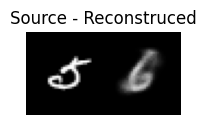

In [10]:

def reconstruct_images(images, model):
    model.eval()
    with torch.no_grad():
        images, _, _ = model(images.to(device))
        images = images.clamp(0, 1)
        return images



digit = 5 #@param {type:"slider", min:0, max:9, step:1}
digits_style = 20 #@param {type:"slider", min:0, max:42, step:1}

image = label2img[digit][digits_style]
bigimage = torch.cat((image,reconstruct_images(image, vae))).cpu()

mus, logvars = vae.encoder(image)
std = (logvars // 2 ).exp().squeeze().cpu()
mus = mus.squeeze().cpu()

plt.figure(figsize = (2, 17))
plt.imshow(torchvision.utils.make_grid(bigimage, 10, 5).permute(1, 2, 0))
plt.title("Source - Reconstruced")
plt.axis('off')
plt.show()


samples = 5000
bivariate_nd = torch.distributions.MultivariateNormal(loc=mus, covariance_matrix=std.diag())
bidist = bivariate_nd.sample((samples,))

fig = go.Figure()
fig.add_trace(go.Histogram2d(x=bidist[:, 0], y=bidist[:, 1],
                             xbins=dict(start=-5, end=5, size=0.1),
                             ybins=dict(start=-5, end=5, size=0.1),
                             histnorm='probability'))
fig.update_traces(opacity=0.6)
fig.update_layout(
    title="Distribution from which we sample for each image",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    ),
    height=800,
    width=800,
    autosize=False,
)
fig.show()


samples = 5000
nd1 = torch.distributions.Normal(loc=mus[0], scale=std[0])
nd2 = torch.distributions.Normal(loc=mus[1], scale=std[1])

dist1 = nd1.sample((samples,))
dist2 = nd2.sample((samples,))

fig = go.Figure()
fig.add_trace(go.Histogram(x=dist1,
                           xbins=dict(start=-5, end=5, size=0.005),
                           histnorm='probability', name="0-th latent dim"))
fig.add_trace(go.Histogram(x=dist2,
                           xbins=dict(start=-5, end=5, size=0.005),
                           histnorm='probability',
                           name="1-th latent dim"))
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.4)
fig.update_layout(
    title="Probability distributions of each latent dimension",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    ),
    height=300
)
fig.show()


### Visualize Reconstructions


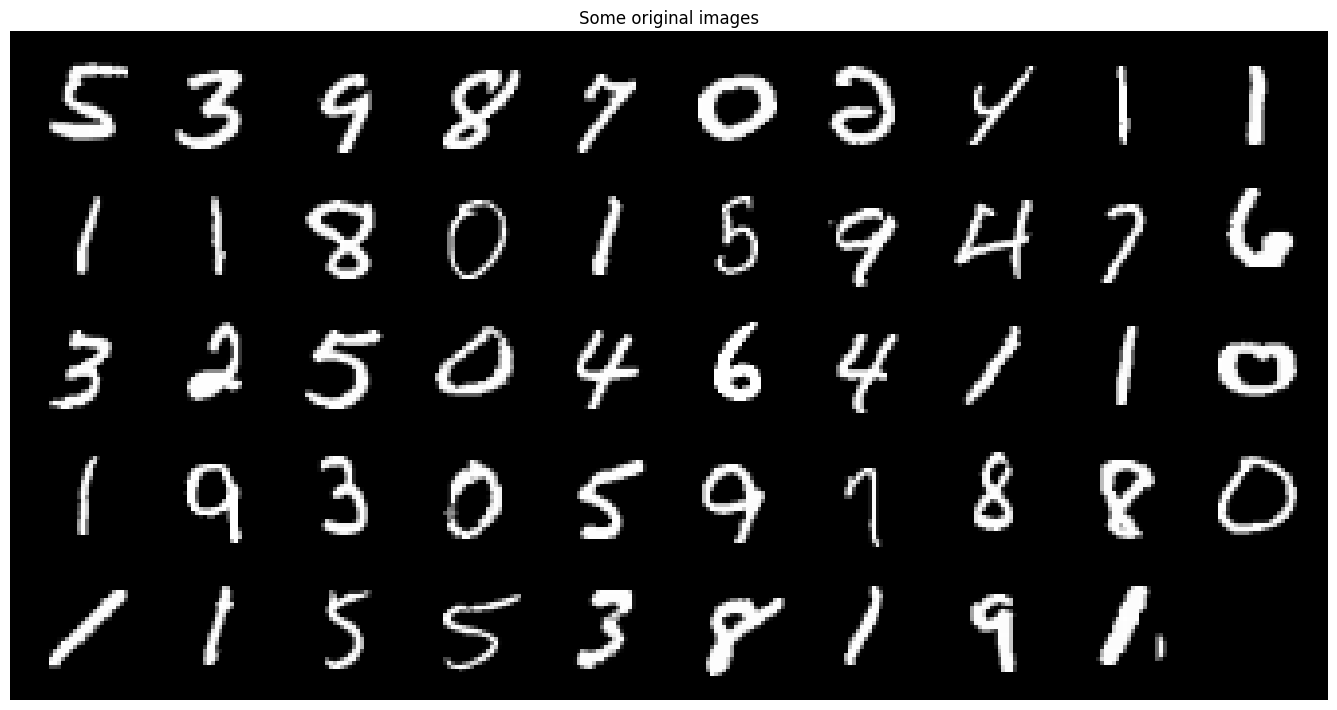

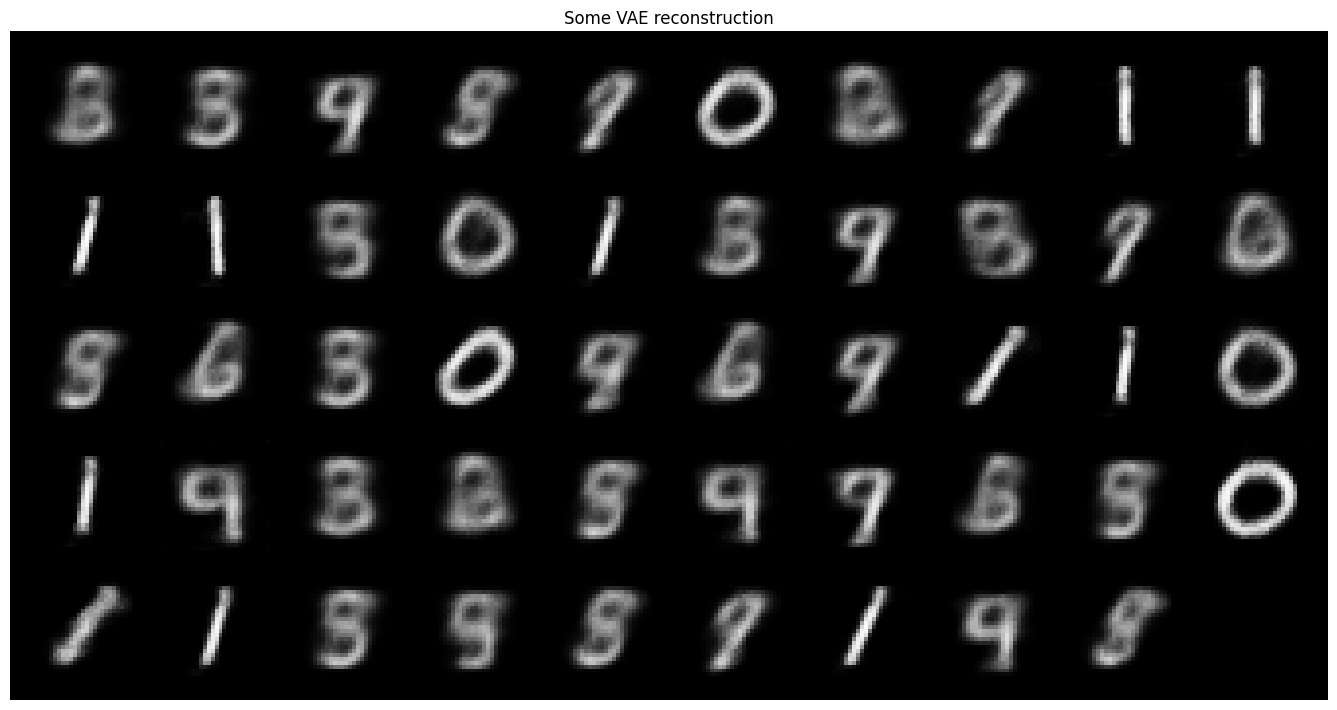

In [12]:
import torchvision.utils

images, labels = next(iter(test_dataloader))
reconstruced_images = reconstruct_images(images, vae).cpu()

# Matplolib plot, much faster for static images
# First visualise the original images
plt.figure(figsize = (17, 17))
plt.imshow(torchvision.utils.make_grid(images[1:50],10,5).permute(1, 2, 0))
plt.title("Some original images")
plt.axis('off')
plt.show()

# Reconstruct and visualise the images using the vae
plt.figure(figsize = (17, 17))
plt.imshow(torchvision.utils.make_grid(reconstruced_images[1:50], 10, 5).permute(1, 2, 0))
plt.title("Some VAE reconstruction")
plt.axis('off')
plt.show()

# # To use plotly:
# # First visualise the original images
# px.imshow(torchvision.utils.make_grid(images[1:50],10,5).permute(1, 2, 0),
#           title="Some original images",
#           color_continuous_scale='grayscale',
#           color_continuous_midpoint=0.5).show()

# # Reconstruct and visualise the images using the vae
# px.imshow(torchvision.utils.make_grid(reconstruced_images[1:50], 10, 5).permute(1, 2, 0),
#           title="Some VAE reconstruction",
#           color_continuous_scale='grayscale',
#           color_continuous_midpoint=0.5).show()

### Interpolate in Latent Space


In [13]:
def interpolation(lambda1, model, img1, img2):

    with torch.no_grad():

        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_2 + (1- lambda1) * latent_1

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.clamp(0, 1).cpu()

        return inter_image

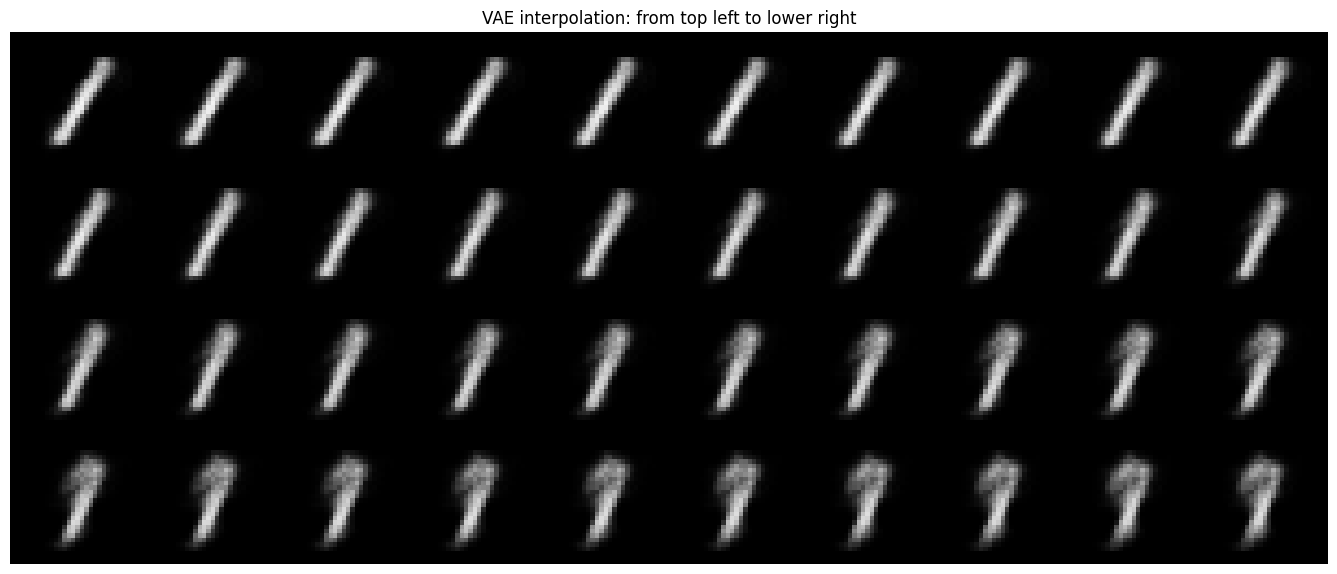

In [14]:
#@title Playground interpolation { run: "auto", output-height: 5000 }

vae.eval()


num_interpolations = 40 #@param {type:"slider", min:10, max:100, step:10}

start_digit = 1 #@param {type:"slider", min:0, max:9, step:1}
end_digit = 7 #@param {type:"slider", min:0, max:9, step:1}
digits_style = 9 #@param {type:"slider", min:0, max:42, step:1}


start_image = label2img[start_digit][digits_style]
end_image = label2img[end_digit][digits_style]

# interpolation lambdas
lambda_range=np.linspace(0,1,num_interpolations)
bigimage = torch.cat([interpolation(x, vae, start_image, end_image) for x in lambda_range])


# Matplolib plot, much faster for static images
plt.figure(figsize = (17, 17))
plt.imshow(torchvision.utils.make_grid(bigimage, 10).permute(1, 2, 0))
plt.title("VAE interpolation: from top left to lower right")
plt.axis('off')
plt.show()

# # To use plotly:
# px.imshow(torchvision.utils.make_grid(bigimage, 10).permute(1, 2, 0),
#           title="VAE interpolation: from top left to lower right",
#           color_continuous_scale='grayscale',
#           color_continuous_midpoint=0.5).show()

### Sample Latent Vector from Prior (VAE as Generator)

By sampling from the latent space, we can use the decoder network to form a generative model capable of creating new data similar to what was observed during training. Specifically, we'll sample from the prior distribution $p(z)$ which we assumed follows a unit Gaussian distribution.

Although the generated digits are not perfect, they are usually better than for a non-variational Autoencoder (compare results for the 10d VAE to the results for the autoencoder).

Similar to autoencoders, the manifold of latent vectors that decode to valid digits is sparser in higher-dimensional latent spaces. Increasing the weight of the KL-divergence term in the loss (increasing `variational_beta`) makes the manifold less sparse at the cost of a lower-quality reconstruction. A pre-trained model with `variational_beta = 10` is available at `./pretrained/vae_10d_beta10.pth`.

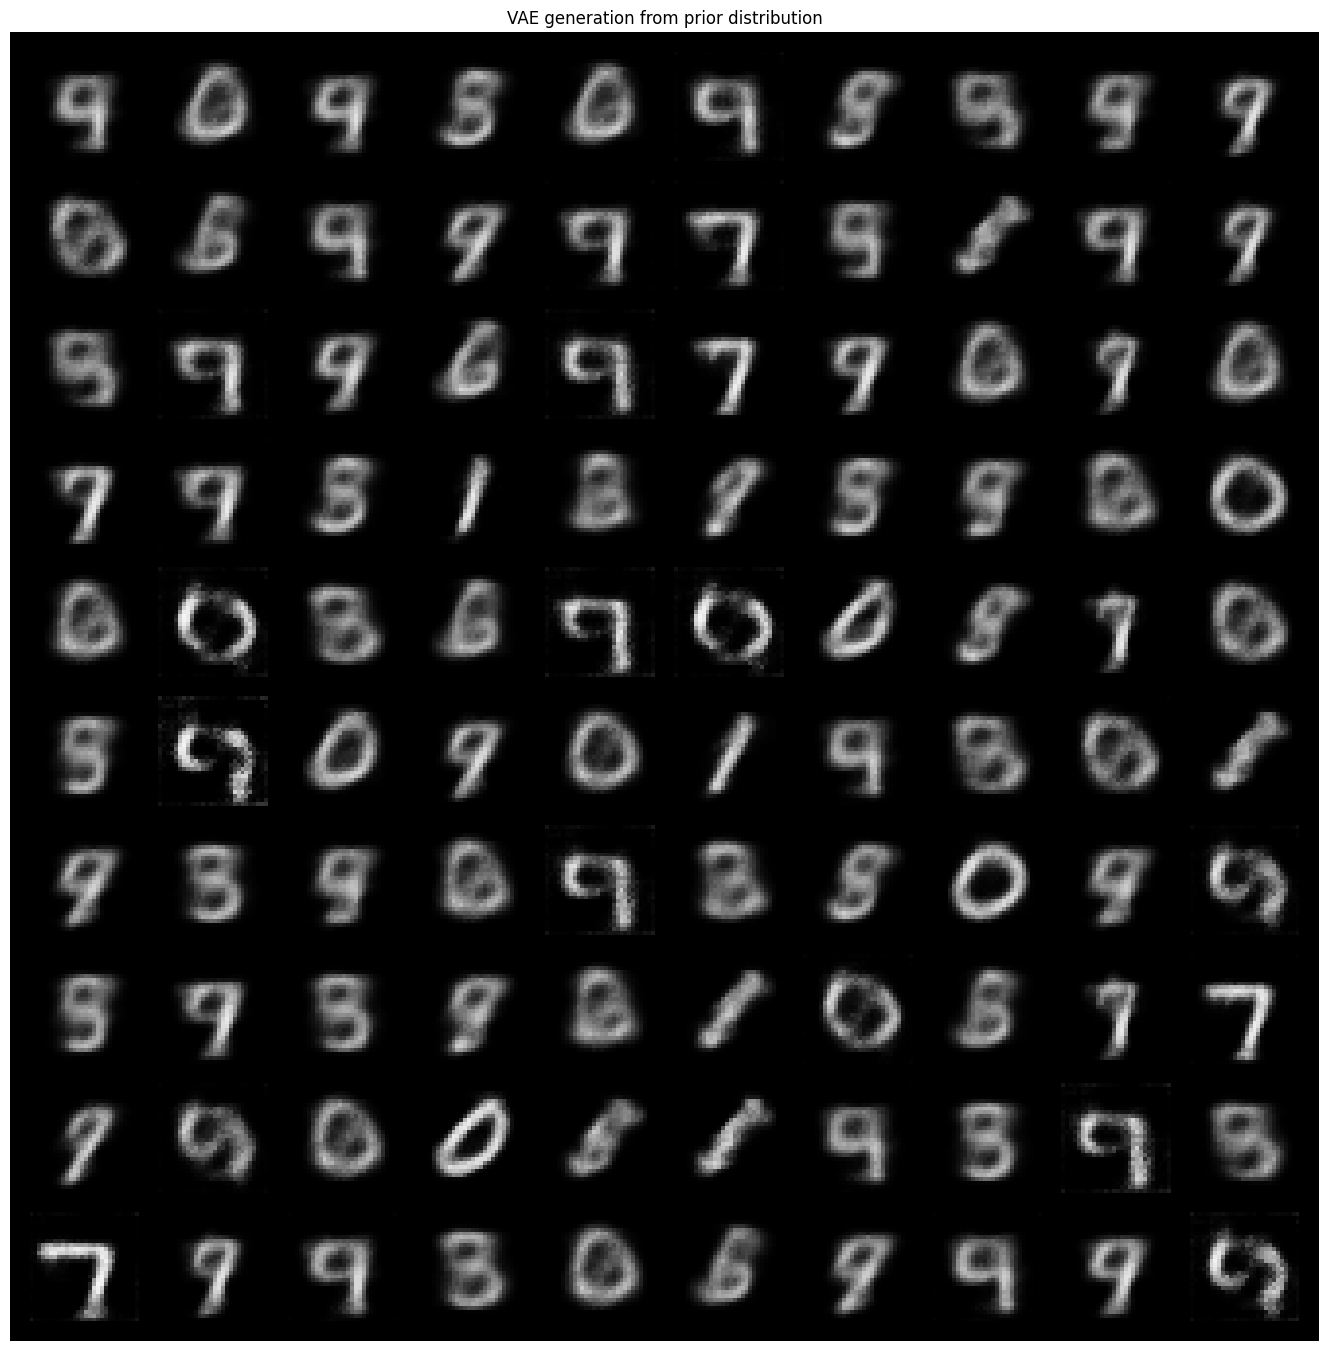

In [15]:
#@title Playground random generations { run: "auto", output-height: 5000 }

vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution, our prior distribution
    latent = torch.randn(128, latent_dims, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu().clamp(0, 1)

    # Matplolib plot, much faster for static images
    plt.figure(figsize = (17, 17))
    plt.imshow(torchvision.utils.make_grid(img_recon.data[:100],10,5).permute(1, 2, 0))
    plt.title("VAE generation from prior distribution")
    plt.axis('off')
    plt.show()

    # # To use plotly:
    # px.imshow(torchvision.utils.make_grid(img_recon.data[:100],10,5).permute(1, 2, 0),
    #       title="VAE generation from prior distribution",
    #       color_continuous_scale='grayscale',
    #       color_continuous_midpoint=0.5,
    #       height=1000).show()

#### 2D Latent Space

The figure below visualizes the data generated by the decoder network of a variational autoencoder trained on the MNIST handwritten digits dataset.

Here, we've linearly interpolated a grid of values and displayed the output of our decoder network.

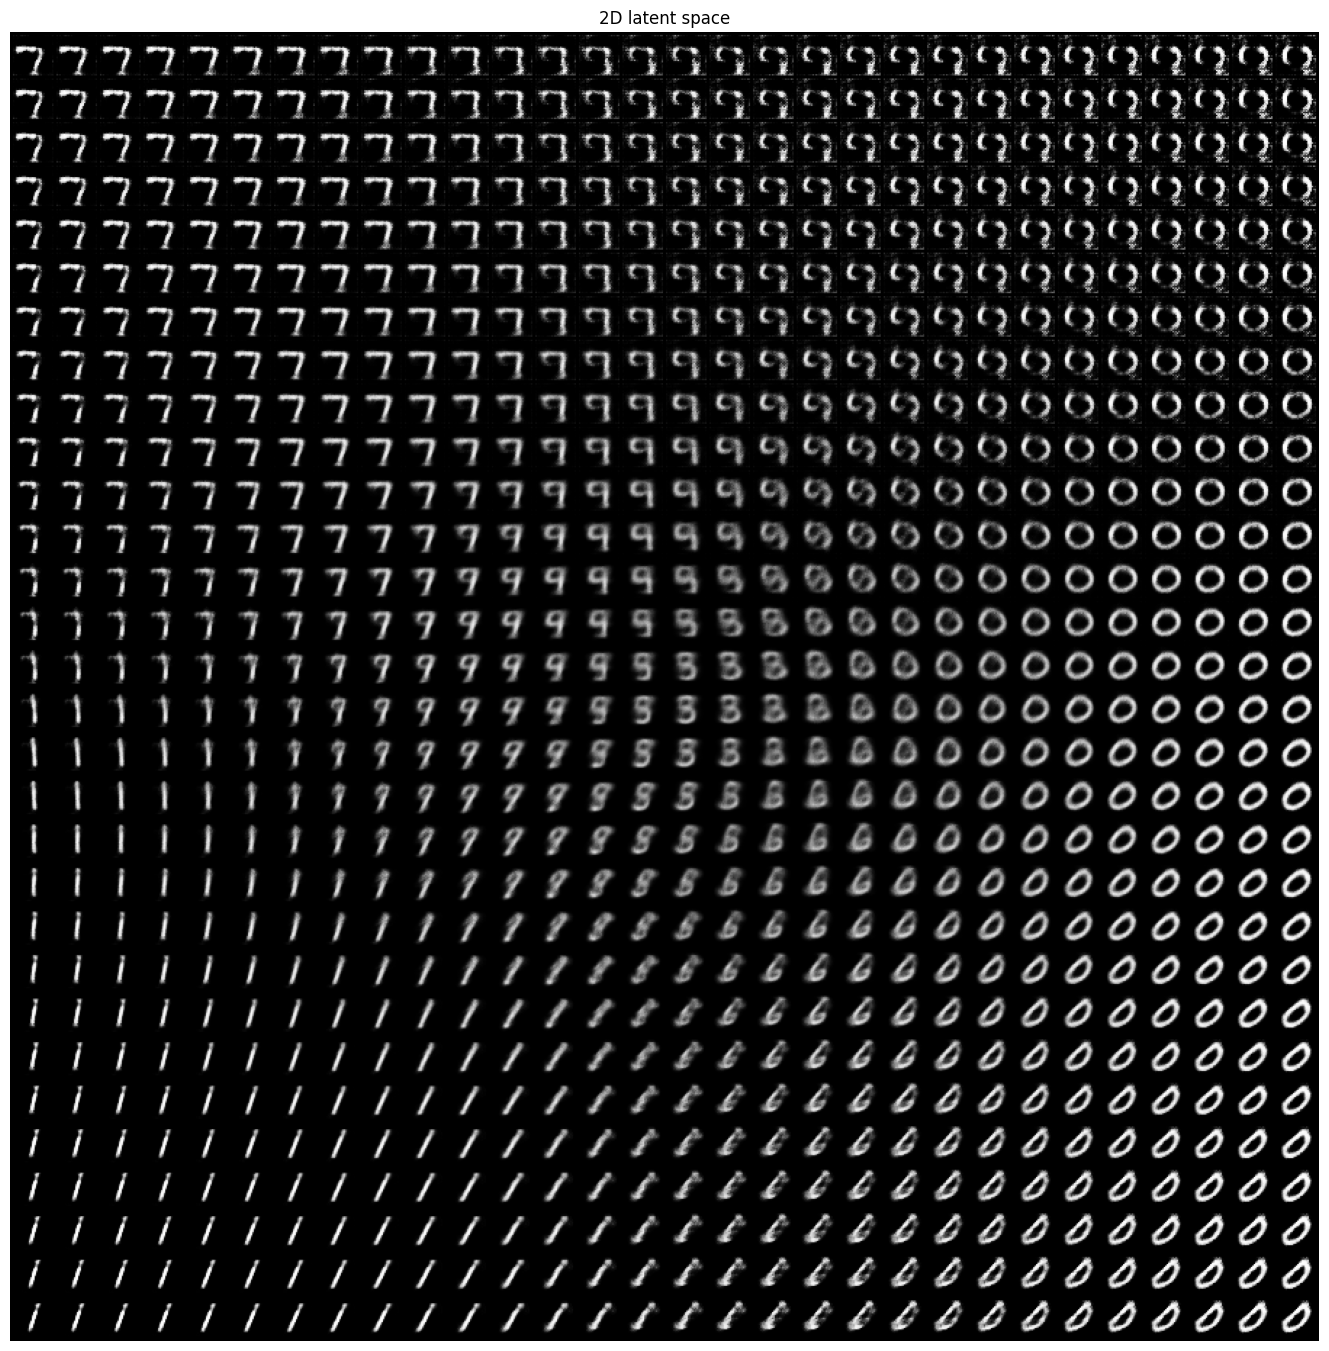

In [16]:
#@title Playground 2D linear interp { run: "auto", output-height: 5000 }

import matplotlib.pyplot as plt

latents_lims = 3.66 #@param {type:"slider", min:0.01, max:4, step:0.05}
num_interpolations = 30 #@param {type:"slider", min:10, max:50, step:2}

# load a network that was trained with a 2d latent space
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')

with torch.no_grad():

    # create a sample grid in 2d latent space
    latent_interpolation = torch.linspace(-latents_lims, latents_lims, num_interpolations)
    latent_grid = torch.stack(
        (
            latent_interpolation.repeat(num_interpolations, 1),
            latent_interpolation[:, None].repeat(1, num_interpolations)
        ), dim=-1).view(-1, 2)

    # reconstruct images from the latent vectors
    latent_grid = latent_grid.to(device)
    image_recon = vae.decoder(latent_grid)
    image_recon = image_recon.cpu()

    # Matplolib plot, much faster for static images
    plt.figure(figsize = (17, 17))
    plt.imshow(torchvision.utils.make_grid(image_recon.data[:num_interpolations ** 2],
                                          num_interpolations).permute(1, 2, 0))
    plt.title("2D latent space")
    plt.axis('off')
    plt.show()

    # To use plotly:
    # px.imshow(torchvision.utils.make_grid(image_recon.data[:num_interpolations ** 2],
    #                                       num_interpolations),
    #       title="2D latent space",
    #       color_continuous_scale='grayscale',
    #       color_continuous_midpoint=0.5,
    #       height=1000).show()

...why is it distorted?

We are doing a linear interpolation over a (multivariate) gaussian distribution!

To get an undistorted sense of the full latent manifold, we can sample and decode latent space coordinates proportionally to the model’s distribution over latent space. In other words, we simply sample relative to our chosen prior distribution over z
. In our case, this means sampling linearly spaced percentiles from the [inverse CDF](http://work.thaslwanter.at/Stats/html/statsDistributions.html#other-important-presentations-of-probability-densities) of a spherical Gaussian.

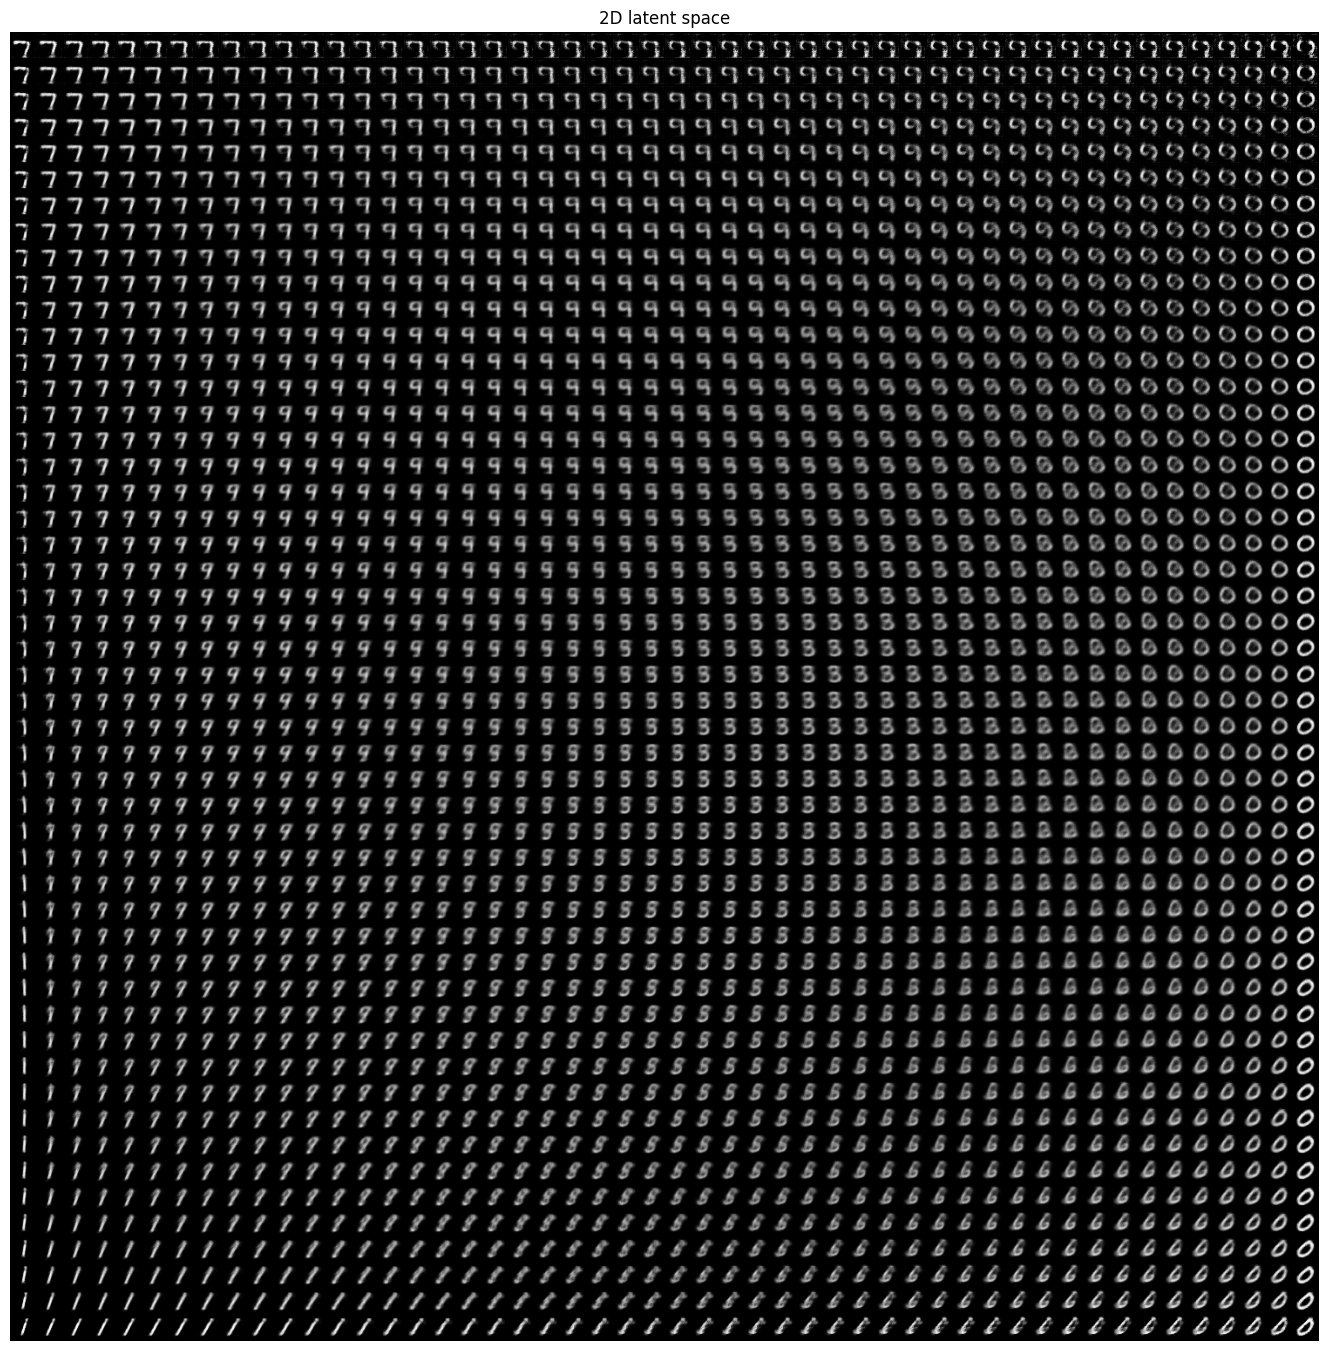

In [17]:
#@title Playground 2D icdf interp { run: "auto", output-height: 5000 }

import matplotlib.pyplot as plt

num_interpolations = 50 #@param {type:"slider", min:10, max:50, step:2}

from scipy import stats

nd = torch.distributions.Normal(loc=torch.as_tensor([0.]),
                                scale=torch.as_tensor([1.]))

with torch.no_grad():

    # create a sample grid in 2d latent space
    latent_interpolation = torch.linspace(0.001, 0.999, num_interpolations)
    latent_grid = torch.stack(
        (
            latent_interpolation.repeat(num_interpolations, 1),
            latent_interpolation[:, None].repeat(1, num_interpolations)
        ), dim=-1).view(-1, 2)

    latent_grid = nd.icdf(latent_grid)
    # reconstruct images from the latent vectors
    latent_grid = latent_grid.to(device)
    image_recon = vae.decoder(latent_grid)
    image_recon = image_recon.cpu()

    # Matplolib plot, much faster for static images
    plt.figure(figsize = (17, 17))
    plt.imshow(torchvision.utils.make_grid(image_recon.data[:num_interpolations ** 2],
                                          num_interpolations).permute(1, 2, 0))
    plt.title("2D latent space")
    plt.axis('off')
    plt.show()


---

Section inspired from [this](https://github.com/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb) tutorial and these blog posts:
[post1](https://blog.fastforwardlabs.com/2016/08/22/under-the-hood-of-the-variational-autoencoder-in.html)
[post2](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/)
[post3](https://www.jeremyjordan.me/variational-autoencoders/), [post4](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf)

### **EXERCISE**

> Play with the `variational_beta` hyperparameter to give more or less importance to the KL divergence and see how the latent space and performance change!